In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event

In [3]:
import os
import numpy as np
import pandas as pd
import glob
import math


import time
from utils import timeSince
from tqdm import tqdm

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

In [5]:
from hit_gauss_predictor import HitGausPredictor
from hit_gauss_predictor import cal_res
from utils import tunable_parameters

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
batch_size = 64
n_epochs = 50
model = HitGausPredictor(batch_size=batch_size, device=device).to(device)
print('total tunable parameters:', tunable_parameters(model))

total tunable parameters: 230


In [8]:
model.load_state_dict(torch.load('model_hitGaus', map_location=lambda storage, loc: storage))

In [9]:
import pickle
track_arrays = pickle.load(open('input/ten_hists_normed.npy', 'rb'))

In [10]:
print('total tracks:', track_arrays.shape)

total tracks: (1594060, 10, 3)


In [11]:
mean_r, sigma_r = 913.681763, 692.430542
mean_phi, sigma_phi = 0.009939, 1.823752
mean_z, sigma_z = -2.315056, 1061.912476

In [12]:
def cal_res2(model, test_track):
    """
    calculate predicted residual and variances
    of the model, for this test_track.
    test_track's size: [batch_size, n_hits, 3]"""

    test_t = torch.from_numpy(test_track[:, :-1, :])
    target_t = torch.from_numpy(test_track[:, 1:, 1:])
    with torch.no_grad():
        output = model(test_t)
        print(output.size())
        output = output.contiguous().view(-1, output.size(-1))
        means = output[:, 0:2]
        covs = output[:, 2:4]
        
        target_t = target_t.contiguous().view(target_t.size(0)*target_t.size(1),
                                        target_t.size(2))
        print("target size:", target_t.size())

        res = means - target_t
        rho = output[:, 4]
        return res, covs, rho

In [58]:
def cal_res3(model, test_track):
    """
    calculate predicted residual and variances
    of the model, for this test_track.
    test_track's size: [batch_size, n_hits, 3]"""

    print("test track size:", test_track.shape)
    n_events = test_track.shape[0]
    n_batches = int(n_events/batch_size)
    print("number of batches:", n_batches)
    
    with torch.no_grad():
        output_list = []
        for ibatch in range(n_batches):
            start = ibatch*batch_size
            end = start + batch_size
            test_t = torch.from_numpy(test_track[start:end, :-1, :])
            target_t = torch.from_numpy(test_track[start:end, 1:, 1:])
            
            output_tmp = model(test_t)
            output_tmp = output_tmp.contiguous().view(-1, output_tmp.size(-1))
            output_tmp[:, 0:2] = output_tmp[:, 0:2] - target_t.contiguous().view(-1, target_t.size(-1))
            output_list.append(output_tmp)
           
        print("number of output items:", len(output_list))
        output = torch.cat(output_list)
        print(output.size())
        return output

In [41]:
def gaus_llh_loss(outputs, targets):
    """Custom gaussian log-likelihood loss function"""
    if torch.isnan(outputs).any():
        raise Exception("Net's output is NAN")
    batches = outputs.size(0)
    hits = outputs.size(1)

    # Flatten layer axis into batch axis to use batch matrix operations
    outputs = outputs.contiguous().view(-1, outputs.size(-1))
    targets = targets.contiguous().view(-1, targets.size(-1))

    # Calculate the residual error
    dx1 = targets[:, 0] - outputs[:, 0]
    dx2 = targets[:, 1] - outputs[:, 1]
    c1 =  outputs[:, 2]
    c2 =  outputs[:, 3]
    rho = outputs[:, 4]

    det_sigma = (1 - rho*rho) * c1 * c2
    log_det = torch.log(det_sigma)
    chi2 = (dx1*dx1/c1 + dx2*dx2/c2 - 2*rho*dx1*dx2/torch.sqrt(c1*c2))/(1-rho*rho)
    print(det_sigma[0], log_det[0], chi2[0], dx1[0], c1[0], dx2[0], c2[0], rho[0])
    prob = log_det + chi2

    return torch.sum(prob)/batches/hits

In [39]:
start = 894060
n_samples = 100000

In [49]:
residule, covs, rho = cal_res2(model, np.array(track_arrays[start:start+batch_size]))
res_phi = residule.numpy()[:, 0]*sigma_phi + mean_phi
res_z = residule.numpy()[:, 1]*sigma_z + mean_z

torch.Size([64, 9, 5])
target size: torch.Size([576, 2])


In [59]:
out = cal_res3(model, np.array(track_arrays[start:start+n_samples]))

test track size: (100000, 10, 3)
number of batches: 1562
number of output items: 1562
torch.Size([899712, 5])


In [211]:
out_cp = out.clone()
out_cp[:, 0] = out_cp[:, 0]*sigma_phi
out_cp[:, 1] = out_cp[:, 1]*sigma_z
out_cp[:, 2] = out_cp[:, 2]*sigma_phi**2
out_cp[:, 3] = out_cp[:, 3]*sigma_z**2
out_batches = out_cp.contiguous().view(-1, 9, 5)

Text(0,0.5,'predicted hits')

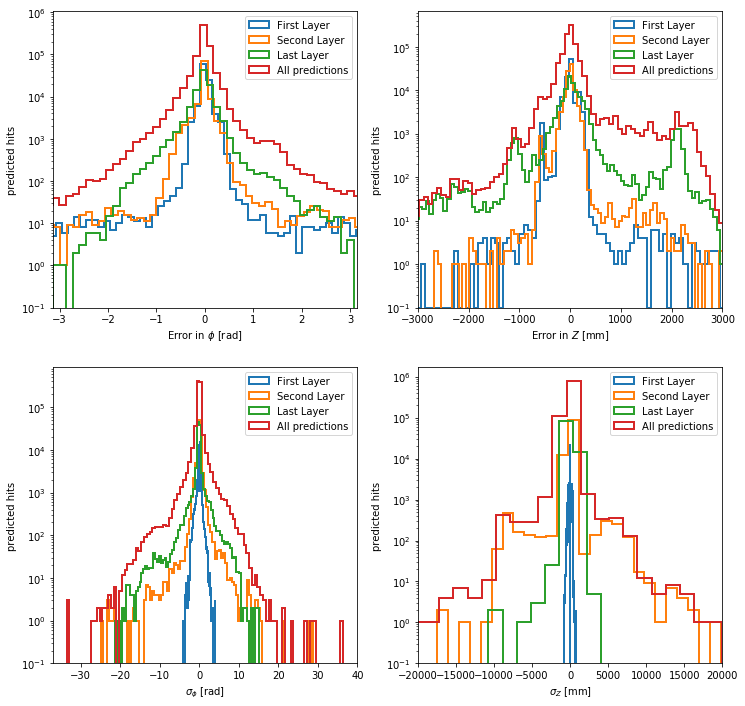

In [213]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(221)
ax.set_xlim(-np.pi, np.pi)
nbins = 100
#jj = plt.hist(res_z, bins=100, histtype='step', lw=2)
# jj = plt.hist(residule.view(batch_size, -1, 2).numpy()[:, 0, 0] * sigma_phi + mean_phi)
res = plt.hist(out_batches.numpy()[:, 0, 0],
               bins=nbins, histtype='step', label="First Layer", lw=2, log=True)
res = plt.hist(out_batches.numpy()[:, 1, 0],
               bins=nbins, histtype='step', label="Second Layer", lw=2)
res = plt.hist(out_batches.numpy()[:, 8, 0],
               bins=nbins, histtype='step', label="Last Layer", lw=2)
res = plt.hist(out_batches.numpy()[:, :, 0].flatten(),
               bins=nbins, histtype='step', label="All predictions", lw=2)
ax.legend()
ax.set_xlabel("Error in $\phi$ [rad]")
ax.set_ylabel('predicted hits')

ax3 = fig.add_subplot(223)
res = plt.hist(np.sqrt(out_batches.numpy()[:, 0, 2])*np.sign(out_batches.numpy()[:, 0, 0]),
               bins=nbins, histtype='step', label="First Layer", lw=2, log=True)
res = plt.hist(np.sqrt(out_batches.numpy()[:, 1, 2])*np.sign(out_batches.numpy()[:, 1, 0]),
               bins=nbins, histtype='step', label="Second Layer", lw=2)
res = plt.hist(np.sqrt(out_batches.numpy()[:, 8, 2])*np.sign(out_batches.numpy()[:, 8, 0]),
               bins=nbins, histtype='step', label="Last Layer", lw=2)
res = plt.hist(np.sqrt(out_batches.numpy()[:, :, 2].flatten())*np.sign(out_batches.numpy()[:, :, 0].flatten()),
               bins=nbins, histtype='step', label="All predictions", lw=2)
ax3.legend()
ax3.set_xlabel("$\sigma_\phi$ [rad]")
ax3.set_ylabel('predicted hits')


ax2 = fig.add_subplot(222)
ax2.set_xlim(-3000, 3000)
res = plt.hist(out_batches.numpy()[:, 0, 1],
               bins=nbins, histtype='step', label="First Layer", lw=2, log=True)
res = plt.hist(out_batches.numpy()[:, 1, 1],
               bins=nbins, histtype='step', label="Second Layer", lw=2)
res = plt.hist(out_batches.numpy()[:, 8, 1],
               bins=nbins, histtype='step', label="Last Layer", lw=2)
res = plt.hist(out_batches.numpy()[:, :, 1].flatten(),
               bins=nbins, histtype='step', label="All predictions", lw=2)
# res = plt.hist(out_batches.numpy()[:, 8, 0]*sigma_phi+mean_phi, bins=100, histtype='step')
ax2.legend()
ax2.set_xlabel("Error in $Z$ [mm]")
ax2.set_ylabel('predicted hits')


ax4 = fig.add_subplot(224)
ax4.set_xlim(-20000, 20000)
res = plt.hist(np.sqrt(out_batches.numpy()[:, 0, 3])*np.sign(out_batches.numpy()[:, 0, 1]),
               bins=nbins, histtype='step', label="First Layer", lw=2, log=True)
res = plt.hist(np.sqrt(out_batches.numpy()[:, 1, 3])*np.sign(out_batches.numpy()[:, 1, 1]),
               bins=nbins, histtype='step', label="Second Layer", lw=2)
res = plt.hist(np.sqrt(out_batches.numpy()[:, 8, 3])*np.sign(out_batches.numpy()[:, 8, 1]),
               bins=nbins, histtype='step', label="Last Layer", lw=2)
res = plt.hist(np.sqrt(out_batches.numpy()[:, :, 3].flatten())*np.sign(out_batches.numpy()[:, :, 1].flatten()),
               bins=nbins, histtype='step', label="All predictions", lw=2)
# res = plt.hist(out_batches.numpy()[:, 8, 0]*sigma_phi+mean_phi, bins=100, histtype='step')
ax4.legend()
ax4.set_xlabel("$\sigma_Z$ [mm]")
ax4.set_ylabel('predicted hits')

### Visual each track prediction

In [166]:
def get_output(model, test_track):
    """
    calculate predicted residual and variances
    of the model, for this test_track.
    test_track's size: [batch_size, n_hits, 3]"""

    print("test track size:", test_track.shape)
    n_events = test_track.shape[0]
    n_batches = int(n_events/batch_size)
    print("number of batches:", n_batches)
    
    with torch.no_grad():
        output_list = []
        for ibatch in range(n_batches):
            start = ibatch*batch_size
            end = start + batch_size
            test_t = torch.from_numpy(test_track[start:end, :-1, :])
            
            output_tmp = model(test_t)
            output_list.append(output_tmp)
           
        print("number of output items:", len(output_list))
        output = torch.cat(output_list)
        print(output.size())
#         output[:, 0] = output[:, 0]*sigma_phi + mean_phi
#         output[:, 1] = output[:, 1]*sigma_z + mean_z
#         output[:, 2] = output[:, 2]*sigma_phi**2
#         output[:, 3] = output[:, 3]*sigma_z**2
        return output

In [167]:
pred_out = get_output(model, np.array(track_arrays[start:start+n_samples]))

test track size: (100000, 10, 3)
number of batches: 1562
number of output items: 1562
torch.Size([99968, 9, 5])


In [199]:
def plot(idx):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(121)
    target = track_arrays[start+idx, 1:, 1]
    predict = pred_out.numpy()[idx, :, 0]
    err = np.sqrt(pred_out.numpy()[idx, :, 2])
    ax.errorbar(np.arange(9), target, fmt='-*', lw=2, ms=10, label='target')
    ax.errorbar(np.arange(9), predict, yerr=err, fmt='.', lw=2, ms=10, label='prediction')
    ax.set_ylim(-3, 3)
    ax.set_ylabel('$\phi$')
    ax.set_xlabel('layer')
    ax.legend()

    ax1 = fig.add_subplot(122)
    target2 = track_arrays[start+idx, 1:, 2]
    predict2 = pred_out.numpy()[idx, :, 1]
    err2 = np.sqrt(pred_out.numpy()[idx, :, 3])
    ax1.errorbar(np.arange(9), target2, fmt='-*', lw=2, ms=10, label='target')
    ax1.errorbar(np.arange(9), predict2, yerr=err2, fmt='.', lw=2, ms=10, label='prediction')
    ax1.set_ylim(-3, 3)
    ax1.set_ylabel('$Z$')
    ax1.set_xlabel('layer')
    ax1.legend()

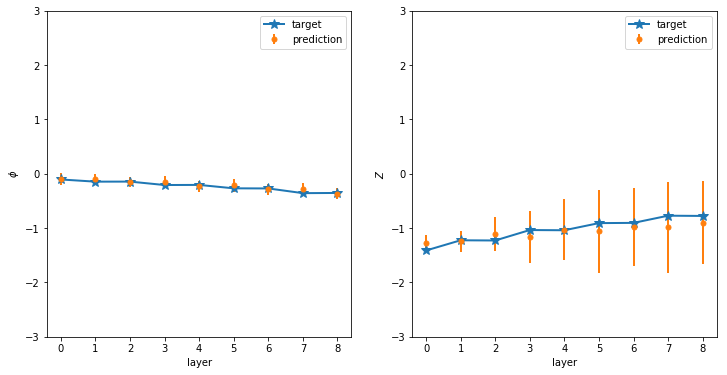

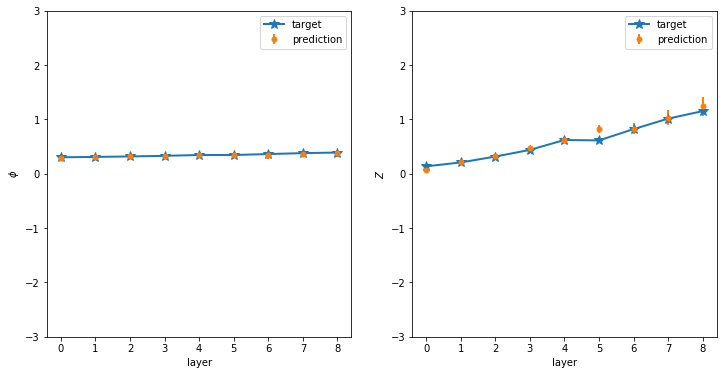

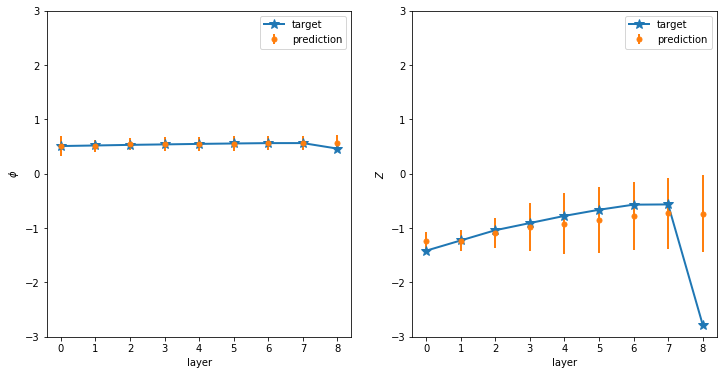

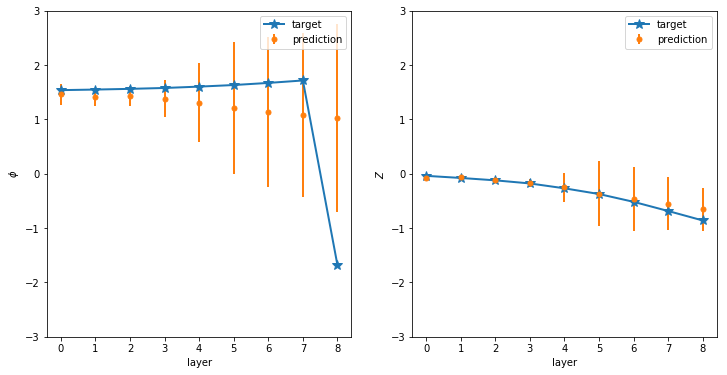

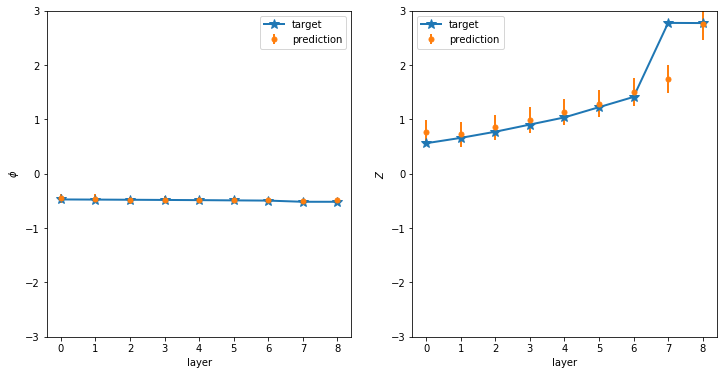

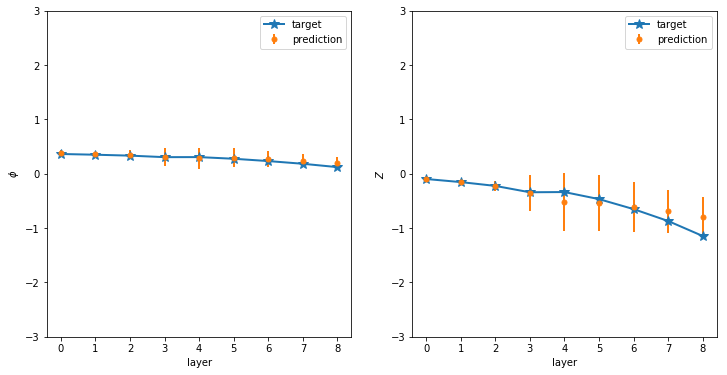

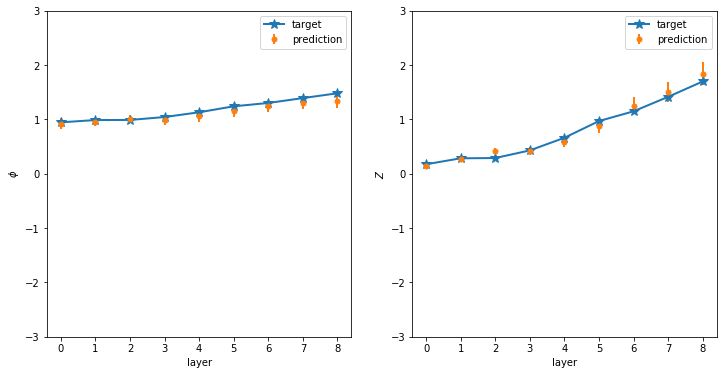

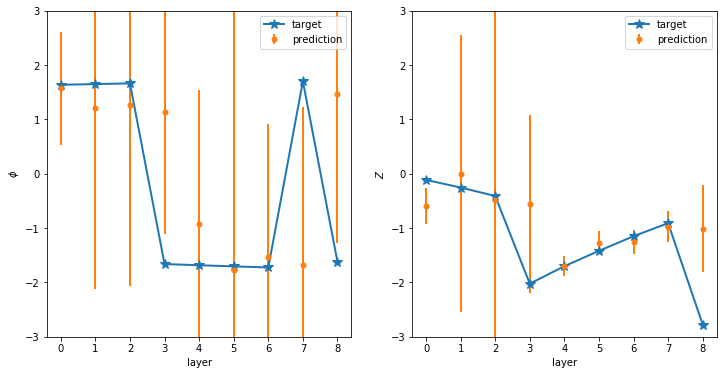

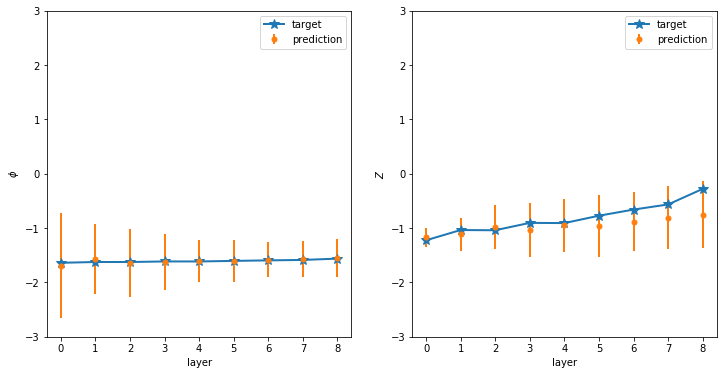

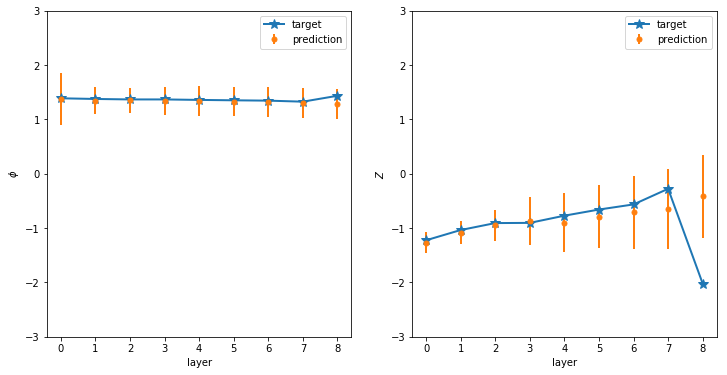

In [203]:
for n in range(10):
    plot(n)

In [42]:
with torch.no_grad():
    output = model( torch.from_numpy(track_arrays[start:start+64, :-1, :]) )
    target = torch.from_numpy(track_arrays[start:start+64, 1:, 1:])
    res = gaus_llh_loss(output, target)

tensor(1.00000e-04 *
       3.0323) tensor(-8.1010) tensor(0.7786) tensor(1.00000e-03 *
       -4.5569) tensor(1.00000e-02 *
       1.2853) tensor(-0.1350) tensor(1.00000e-02 *
       2.3705) tensor(1.00000e-02 *
       -6.8757)


/global/project/projectdirs/m1092/xju/miniconda3/envs/py3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/global/project/projectdirs/m1092/xju/miniconda3/envs/py3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


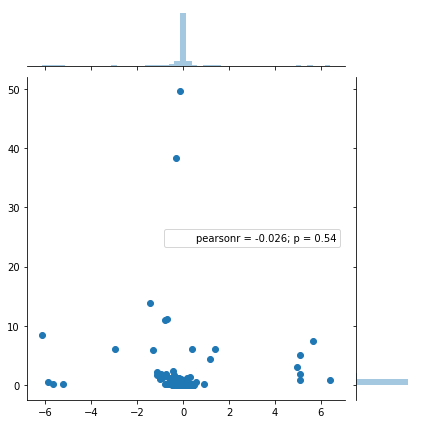

In [34]:
sns.jointplot(res_phi, covs.numpy()[:, 0])

/global/project/projectdirs/m1092/xju/miniconda3/envs/py3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/global/project/projectdirs/m1092/xju/miniconda3/envs/py3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


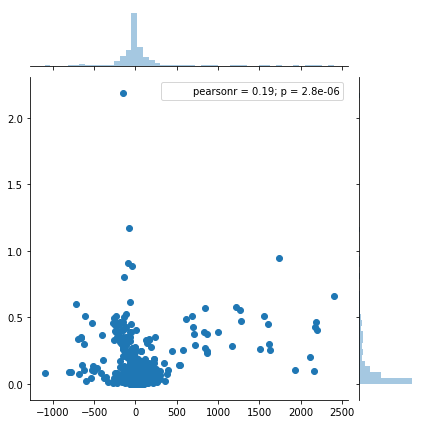

In [22]:
sns.jointplot(res_z, covs.numpy()[:, 1])

(array([  2.,   0.,   0.,   1.,   4.,  30., 508.,  25.,   3.,   3.]),
 array([-176522.96875, -149034.13125, -121545.29375,  -94056.45625,
         -66567.61875,  -39078.78125,  -11589.94375,   15898.89375,
          43387.73125,   70876.56875,   98365.40625]),
 <a list of 10 Patch objects>)

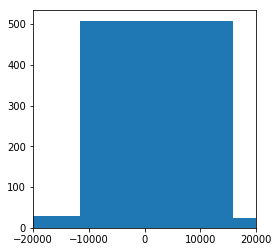

In [30]:
fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_subplot(111)
ax1.set_xlim(-20000, 20000)
plt.hist(res_z/covs.numpy()[:, 1])

(array([ 10.,  19.,  36., 100.,  87., 110.,  86.,  55.,  55.,  18.]),
 array([-0.19493875, -0.15969172, -0.1244447 , -0.08919767, -0.05395064,
        -0.01870362,  0.01654341,  0.05179044,  0.08703746,  0.12228449,
         0.15753151]),
 <a list of 10 Patch objects>)

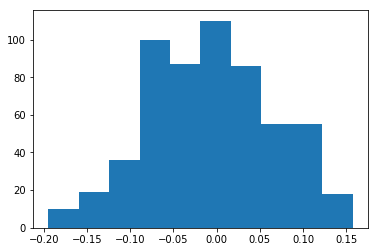

In [23]:
plt.hist(rho)

In [48]:
loss_train = pickle.load(open('loss_trainGauss.pkl', 'rb'))

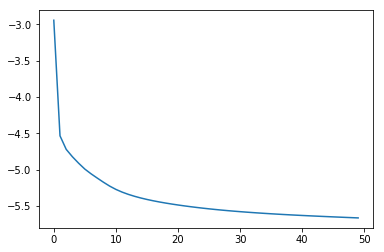

In [49]:
plt.plot(np.arange(0, len(loss_train)), loss_train)

### How the time cost of each epoch changes as a function of batch size.

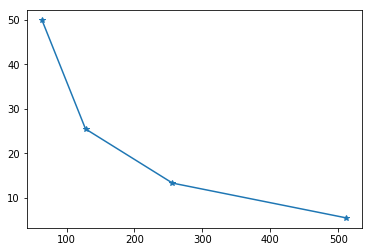

In [44]:
x_batch_size = [64, 128, 256, 512]
y_iter_time = [49.95, 25.51, 13.33, 5.5]
plt.plot(x_batch_size, y_iter_time, '-*')